# Part 1 - Eigenfaces

In [4]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

## Data Preparation

In [5]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [14]:
# Introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# For machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [15]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

## NumPy PCA (CPU)

### PCA Algorithm

In [16]:
# Center data
mean = np.mean(X_train, axis=0)

X_train -= mean
X_test -= mean

# Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

# Project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


### Result Evaluation

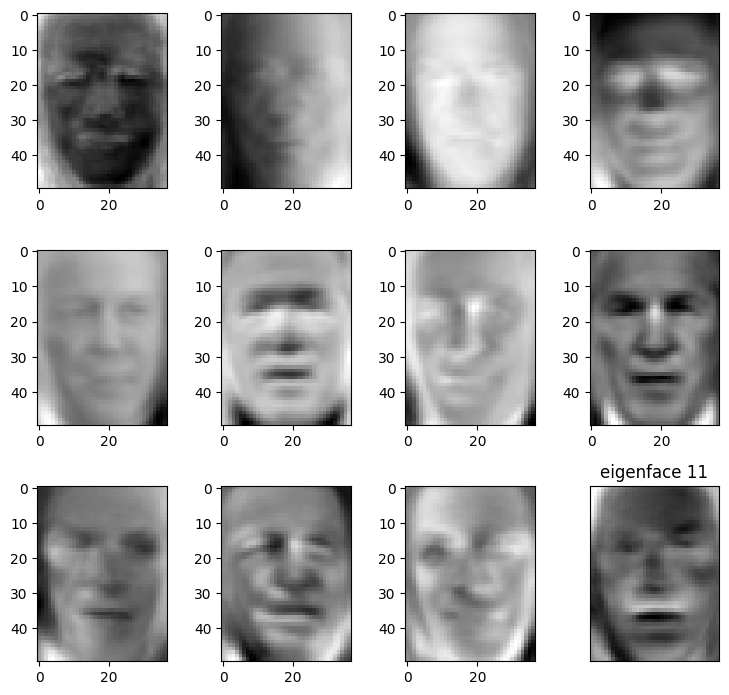

In [17]:
import matplotlib.pyplot as plt

# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
        
plt.show()

(966,)


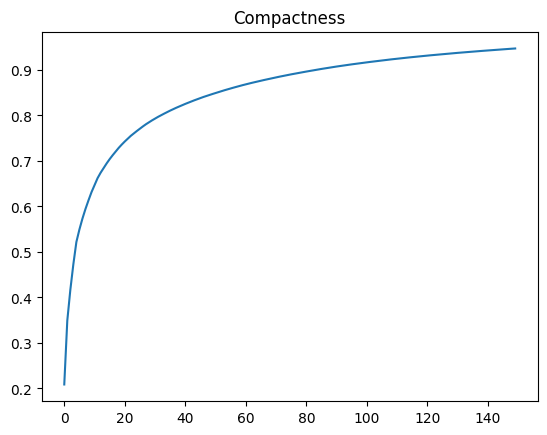

In [18]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) # expects X as [n_samples, n_features]

predictions = estimator.predict(X_test_transformed)

In [20]:
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
# print("Predictions", predictions)
# print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)

print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Total Correct: 205
Accuracy: 0.6366459627329193
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.08      0.14        13
     Colin Powell       0.70      0.63      0.67        60
  Donald Rumsfeld       0.50      0.19      0.27        27
    George W Bush       0.63      0.90      0.75       146
Gerhard Schroeder       0.62      0.40      0.49        25
      Hugo Chavez       0.58      0.47      0.52        15
       Tony Blair       0.57      0.33      0.42        36

         accuracy                           0.64       322
        macro avg       0.66      0.43      0.46       322
     weighted avg       0.64      0.64      0.60       322



## PyTorch PCA (CUDA)

In [21]:
import torch

print("PyTorch Version :\t", torch.__version__)
print("CUDA Available? :\t", torch.cuda.is_available())

PyTorch Version :	 2.0.1+cu118
CUDA Available? :	 True


In [22]:
# Load data onto GPU
X_train_cuda = torch.tensor(X_train, device="cuda")
y_train_cuda = torch.tensor(y_train, device="cuda")
X_test_cuda = torch.tensor(X_test, device="cuda")
y_test_cuda = torch.tensor(y_test, device="cuda")

### PCA Algorithm

In [27]:
# Center data
mean = torch.tensor(mean, device="cuda") # mean was previously calculated
X_train_cuda -= mean
X_test_cuda -= mean

# Eigen-decomposition
U, S, V = torch.linalg.svd(X_train_cuda, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

# Project into PCA subspace
X_transformed_cuda = torch.matmul(X_train_cuda, components.T)
print(X_transformed_cuda.shape)
X_test_transformed_cuda = torch.matmul(X_test_cuda, components.T)
print(X_test_transformed_cuda.shape)

/tmp/ipykernel_20442/3224583841.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, device="cuda") # mean was previously calculated


torch.Size([966, 150])
torch.Size([322, 150])


### Result Evaluation

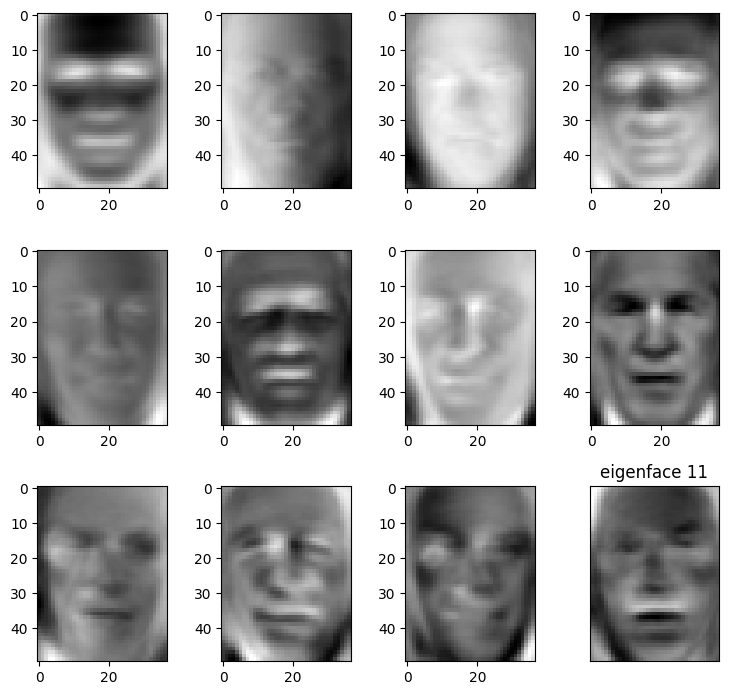

In [29]:
plot_gallery(eigenfaces.to("cpu"), eigenface_titles, h, w)

plt.show()

torch.Size([966])


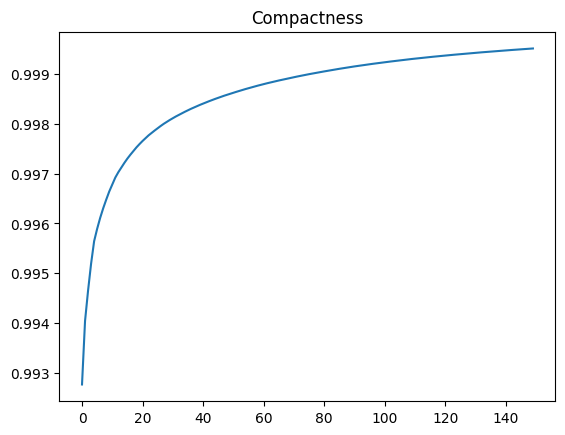

In [32]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio.to("cpu"))
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

### Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
# print("Predictions", predictions)
# print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)

print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Total Correct: 209
Accuracy: 0.6490683229813664
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.68      0.63      0.66        60
  Donald Rumsfeld       0.80      0.15      0.25        27
    George W Bush       0.64      0.91      0.75       146
Gerhard Schroeder       0.62      0.40      0.49        25
      Hugo Chavez       0.64      0.60      0.62        15
       Tony Blair       0.62      0.42      0.50        36

         accuracy                           0.65       322
        macro avg       0.57      0.44      0.47       322
     weighted avg       0.63      0.65      0.61       322



/home/derenteo/git/comp3710/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/derenteo/git/comp3710/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/derenteo/git/comp3710/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu